In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load datasets
df_red = pd.read_csv('../datasets/winequality-red.csv', sep=';')
df_white = pd.read_csv('../datasets/winequality-white.csv', sep=';')

# Inspect the red whine dataset
df_red.head()
df_white.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
# The datasets look similar. Let's test if they have the same features and types.
def columns_and_types_are_equal(df1, df2):
    # Check if column names are the same
    if not df1.columns.equals(df2.columns):
        return False

    # Check if data types are the same for each column
    if not df1.dtypes.equals(df2.dtypes):
        return False

    return True

print(columns_and_types_are_equal(df_red, df_white))

True


In [4]:
# Since both datasets have the same features and types we can combine them.

# First add a color column.
df_red_copy = df_red.copy()
df_white_copy = df_white.copy()

# Add a color column
df_red_copy['color'] = 'red'
df_white_copy['color'] = 'white'

# Combine red and white wine datasets
df_combined = pd.concat([df_red_copy, df_white_copy], ignore_index=True)
print(f"The dataframe has {df_combined.shape[0]} rows and {df_combined.shape[1]} columns")
df_combined.info()
df_combined.describe()

The dataframe has 6497 rows and 13 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [5]:
# Check for missing values
print(df_combined.isnull().sum())

# Check the value range for the 'quality' feature.
num_unique_values = df_combined['quality'].nunique()
print("Number of unique values:", num_unique_values)
unique_values = df_combined['quality'].unique()
print("Unique values:", unique_values)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64
Number of unique values: 7
Unique values: [5 6 7 4 8 3 9]


In [6]:
# Luckily there are no missing values, but if there were we could have:
# 1) Dropped the rows with missing values.
# 2) Imputated the missing values.

# In this case the missing values will be dropped for completeness.
clean_df = df_combined.copy()
clean_df.dropna(inplace=True)

# Next the features are renamed to not contain any spaces in order to be able to use pydantic schemas correctly.
def format_feature_names(input_string: str) -> str:
    # Split the string by whitespace and capitalize each word
    words = input_string.split()
    capitalized_words = [word[0].upper() + word[1:] for word in words]

    # Join the capitalized words without spaces
    formatted_string = ''.join(capitalized_words)

    return formatted_string

# Get rid of spaces in features in order to use pydantic schema for validation. This is not very important here, but will be used in the code base.
clean_df.columns = [format_feature_names(col) for col in clean_df.columns]
print(clean_df.columns)

Index(['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
       'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'PH',
       'Sulphates', 'Alcohol', 'Quality', 'Color'],
      dtype='object')


In [7]:
# Set static variables.
num_vars = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
       'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'PH',
       'Sulphates', 'Alcohol']
cat_vars = ['Color']
features = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
       'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'PH',
       'Sulphates', 'Alcohol', 'Color']
target = ['Quality']

In [8]:
# --- Training Pipeline --- #

wine_pipeline = Pipeline(
    [
        # --- IMPUTATION --- #
        # NOTE: This is not needed for this specific project. Added for demonstrating purposes only. Below code will not
        # have any effect.
        (
            "missing_imputation",
            CategoricalImputer(
                imputation_method="missing",
                variables=cat_vars
            ),
        ),
        # One could add a missing indicator like this. Not needed in this project though as there are no missing values
        # in the training dataset.
        # (
        #     "missing_indicator",
        #     AddMissingIndicator(variables=config.model_config.numerical_vars),
        # ),
        # impute numerical variables with the mean. Not needed in this project though as there are no missing values
        # in the training dataset. Below code will not have any effect.
        (
            "mean_imputation",
            MeanMedianImputer(
                imputation_method="mean",
                variables=num_vars
            ),
        ),

        # --- Categorical encoding --- #
        # encode categorical variables using the target mean
        (
            "onehot_encoder",
            ColumnTransformer(
                transformers=[
                    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'),
                     cat_vars)
                ],
                remainder='passthrough'  # This will leave the other variables unchanged
            ),
        ),

        # --- Scaling --- #
        ('scaler', StandardScaler()),

        # --- Classification --- #
        ('classifier', RandomForestClassifier(n_estimators=500,
                                              random_state=6))

    ]
)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(clean_df[features], clean_df[target], test_size=0.1, random_state=6)
y_train = y_train.values.ravel()  # Many ML libraries expect y_train to be a 1D array

In [10]:
# --- Fit Random Forest Pipeline --- #
wine_pipeline.fit(X_train, y_train)


Pipeline(steps=[('missing_imputation', CategoricalImputer(variables=['Color'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['FixedAcidity', 'VolatileAcidity',
                                              'CitricAcid', 'ResidualSugar',
                                              'Chlorides', 'FreeSulfurDioxide',
                                              'TotalSulfurDioxide', 'Density',
                                              'PH', 'Sulphates', 'Alcohol'])),
                ('onehot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Color'])])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(n_estimators=500, random_state=6))])

In [11]:
# Make predictions
y_pred = wine_pipeline.predict(X_test)

# Evaluate the model
random_forest_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {random_forest_accuracy}\n')
print(classification_report(y_test, y_pred, zero_division=1))


Accuracy on test set: 0.6876923076923077

              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.09      0.17        22
           5       0.73      0.70      0.72       212
           6       0.64      0.80      0.71       280
           7       0.74      0.59      0.65       114
           8       1.00      0.29      0.45        17

    accuracy                           0.69       650
   macro avg       0.85      0.41      0.45       650
weighted avg       0.71      0.69      0.67       650



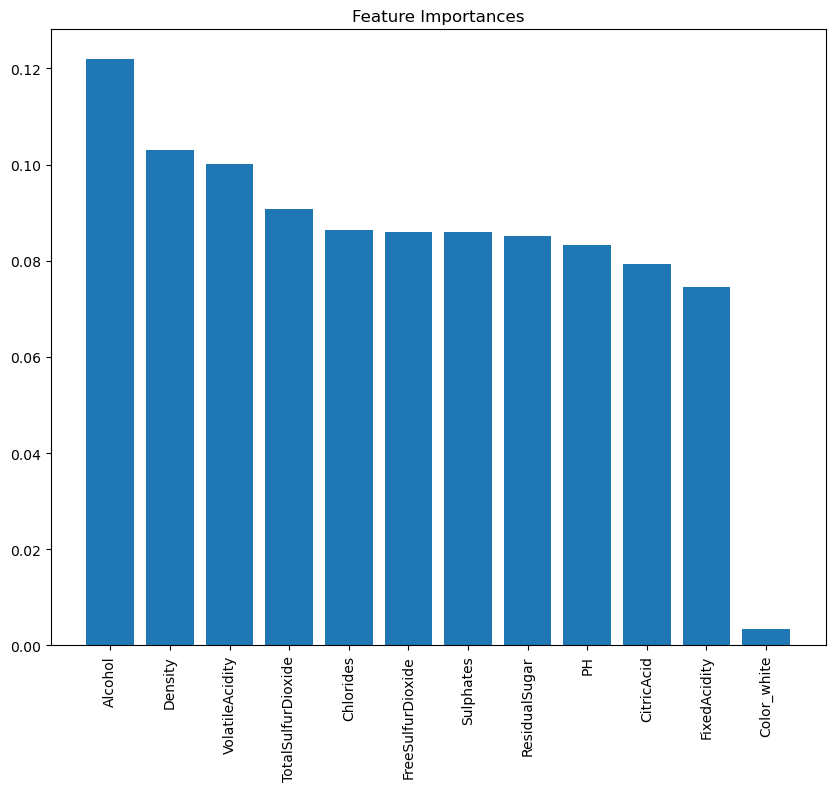

In [12]:
# --- Feature importances --- #
# Extract model from pipeline.
model = wine_pipeline.named_steps['classifier']

# Extract the preprocessor
preprocessor = wine_pipeline.named_steps['onehot_encoder']

if isinstance(preprocessor, ColumnTransformer):
    # Extract feature names after one-hot encoding
    feature_names = preprocessor.get_feature_names_out()
    # Remove prefixes from feature names
    feature_names = [name.split('__', 1)[-1] for name in feature_names]
else:
    # If no ColumnTransformer, use original feature names
    feature_names = X_train.columns.tolist()

importances = model.feature_importances_
# Ensure feature_names and importances are aligned
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

